
# 🧠 Reconhecimento Facial do Zero (Detecção + Classificação) — TensorFlow + MTCNN
**Funciona no Google Colab.** Este notebook cria um pipeline completo de **detecção de faces** (MTCNN) e **reconhecimento** (CNN com TensorFlow/Keras).

> **Aviso Ético e de Uso Responsável**  
> Utilize este material **apenas** para fins educacionais e de pesquisa. Evite uso em cenários sensíveis sem consentimento explícito e sem adequação à legislação aplicável (LGPD/GPDR, etc.).


## 1) Instalação de dependências

In [1]:

%%bash
pip -q install --upgrade pip
pip -q install tensorflow mtcnn duckduckgo-search opencv-python-headless scikit-learn matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:00


## 2) Imports e Configurações

In [2]:

import os, sys, math, random, shutil, pathlib, time, io, glob, json, requests
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from duckduckgo_search import DDGS
from mtcnn import MTCNN
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

print(tf.__version__)


2.19.0


## 3) Parâmetros do Projeto

In [3]:
# Altere aqui o nome da pessoa pública a ser reconhecida
TARGET_NAME = "Barack Obama"    # exemplo: "Lionel Messi", "Taylor Swift", "Elon Musk"
N_IMAGES = 160                  # quantidade alvo de imagens para baixar
IMG_SIZE = 160                  # tamanho do recorte quadrado da face
MARGIN = 0.3                    # margem ao redor da face detectada (30%)
DATA_DIR = "data_faces"
RAW_DIR = os.path.join(DATA_DIR, "raw")
CROP_DIR = os.path.join(DATA_DIR, "cropped")
TARGET_DIR = os.path.join(CROP_DIR, "TARGET")
OTHER_DIR = os.path.join(CROP_DIR, "OTHER")

for d in [DATA_DIR, RAW_DIR, CROP_DIR, TARGET_DIR, OTHER_DIR]:
    os.makedirs(d, exist_ok=True)

print("Projeto configurado.")
print("Público-alvo:", TARGET_NAME)


Projeto configurado.
Público-alvo: Barack Obama


## 4) Download automático de imagens públicas (DuckDuckGo)

In [4]:
def download_images_duckduckgo(query, max_images=200, out_dir="data_faces/raw"):
    os.makedirs(out_dir, exist_ok=True)
    count = 0
    with DDGS() as ddgs:
        # Busca imagens (safe search moderado)
        for r in ddgs.images(
            keywords=query,
            region="wt-wt",
            safesearch="moderate",
            size=None,
            color=None,
            type_image=None,
            layout=None,
            license_image=None,
            max_results=max_images*2  # busca extra para compensar imagens inválidas
        ):
            if count >= max_images:
                break
            url = r.get("image")
            if not url:
                continue
            try:
                resp = requests.get(url, timeout=10, stream=True, headers={"User-Agent":"Mozilla/5.0"})
                ctype = resp.headers.get("Content-Type","").lower()
                if "image" not in ctype:
                    continue
                ext = ".jpg"
                if "png" in ctype: ext = ".png"
                if "jpeg" in ctype: ext = ".jpg"
                if "webp" in ctype: ext = ".webp"
                fname = os.path.join(out_dir, f"{query.replace(' ','_')}_{count:04d}{ext}")
                with open(fname, "wb") as f:
                    for chunk in resp.iter_content(1024):
                        f.write(chunk)
                count += 1
                time.sleep(0.5) # Add a small delay
            except Exception as e:
                continue
    return count

downloaded = download_images_duckduckgo(TARGET_NAME, max_images=N_IMAGES, out_dir=RAW_DIR)

/tmp/ipython-input-1555688058.py:4: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timez

In [5]:
print(f"Baixadas {downloaded} imagens para: {TARGET_NAME}")

Baixadas 160 imagens para: Barack Obama


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 5) Detecção e recorte das faces (TARGET) com MTCNN

In [12]:
import os
import glob
import cv2
import warnings
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random
from mtcnn.mtcnn import MTCNN

# --- suprime warnings do jupyter_client ---
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client.session")

# detector global
detector = MTCNN()

# -------- função de crop --------
def crop_face_mtcnn(img_rgb, margin=0.3, img_size=160, detector=None):
    if detector is None:
        raise ValueError("Passe o detector MTCNN via parâmetro 'detector'.")

    faces = detector.detect_faces(img_rgb)
    if not faces:
        return None

    # maior face
    best = max(faces, key=lambda f: f['box'][2] * f['box'][3])
    x, y, w, h = best['box']
    x, y, w, h = int(x), int(y), int(w), int(h)

    # corrige coordenadas
    x, y = max(0, x), max(0, y)
    x2, y2 = x + w, y + h

    # margem
    dx, dy = int(w * margin), int(h * margin)
    x, y = max(0, x - dx), max(0, y - dy)
    x2, y2 = min(img_rgb.shape[1], x2 + dx), min(img_rgb.shape[0], y2 + dy)

    if x >= x2 or y >= y2:
        return None

    face = img_rgb[y:y2, x:x2]
    if face.size == 0:
        return None

    return cv2.resize(face, (img_size, img_size))


# -------- função de processamento --------
def process_target_raw_to_crops(raw_dir, out_dir, detector, margin=0.3, img_size=160,
                                log_every=10, verbose=False, show_samples=True, max_samples=3):
    os.makedirs(out_dir, exist_ok=True)
    files = sorted(glob.glob(os.path.join(raw_dir, "*")))

    if not files:
        tqdm.write(f"⚠️ Nenhum arquivo encontrado em: {raw_dir}")
        return 0

    kept = unreadable = noface = errors = 0
    sample_faces = []

    tqdm.write(f"🔎 {len(files)} arquivos encontrados. Iniciando processamento...")

    for path in tqdm(files, desc="Processando imagens", unit="img"):
        try:
            img_bgr = cv2.imread(path)
            if img_bgr is None:
                unreadable += 1
                if verbose:
                    tqdm.write(f"ignorado (não lido): {os.path.basename(path)}")
                continue

            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            face = crop_face_mtcnn(img_rgb, margin=margin, img_size=img_size, detector=detector)

            if face is None:
                noface += 1
                if verbose:
                    tqdm.write(f"sem face: {os.path.basename(path)}")
                continue

            out_path = os.path.join(out_dir, os.path.basename(path) + ".jpg")
            ok = cv2.imwrite(out_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
            if ok:
                kept += 1
                if show_samples and len(sample_faces) < max_samples and random.random() < 0.3:
                    sample_faces.append((os.path.basename(path), face))
            else:
                errors += 1
                tqdm.write(f"falha ao salvar: {out_path}")

            if log_every and kept % log_every == 0:
                tqdm.write(f">>> Salvas: {kept} | Sem face: {noface} | Ilegíveis: {unreadable} | Erros: {errors}")

        except Exception as e:
            errors += 1
            tqdm.write(f"Erro em {path}: {type(e).__name__}: {e}")

    tqdm.write(
        f"\n✅ Concluído.\n"
        f"   Total: {len(files)}\n"
        f"   Salvas: {kept}\n"
        f"   Sem face: {noface}\n"
        f"   Ilegíveis: {unreadable}\n"
        f"   Erros: {errors}\n"
        f"   Saída: {out_dir}"
    )

    if show_samples and sample_faces:
        cols = len(sample_faces)
        plt.figure(figsize=(4*cols, 4))
        for i, (name, face) in enumerate(sample_faces, 1):
            plt.subplot(1, cols, i)
            plt.imshow(face)
            plt.title(name, fontsize=10)
            plt.axis("off")
        plt.show()

    return kept


🔎 160 arquivos encontrados. Iniciando processamento...


Processando imagens:   0%|          | 0/160 [00:00<?, ?img/s]

>>> Salvas: 20 | Sem face: 0 | Ilegíveis: 0 | Erros: 0
>>> Salvas: 40 | Sem face: 0 | Ilegíveis: 0 | Erros: 0
>>> Salvas: 60 | Sem face: 1 | Ilegíveis: 0 | Erros: 0
>>> Salvas: 80 | Sem face: 1 | Ilegíveis: 0 | Erros: 0
>>> Salvas: 100 | Sem face: 1 | Ilegíveis: 0 | Erros: 0
>>> Salvas: 120 | Sem face: 1 | Ilegíveis: 0 | Erros: 0
>>> Salvas: 140 | Sem face: 3 | Ilegíveis: 0 | Erros: 0

✅ Concluído.
   Total: 160
   Salvas: 157
   Sem face: 3
   Ilegíveis: 0
   Erros: 0
   Saída: data_faces/cropped


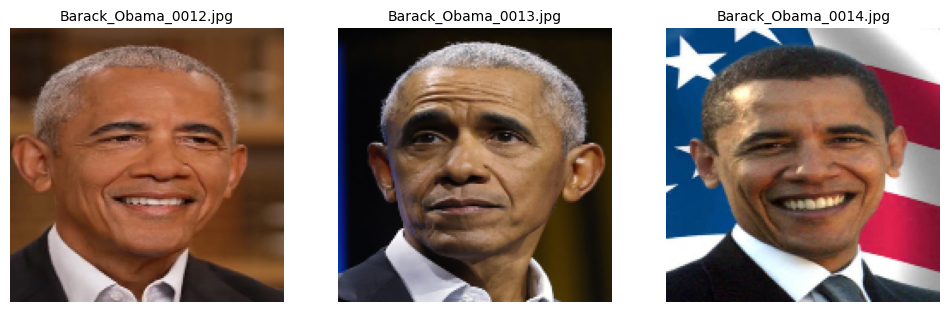

157

In [13]:
# -------- execução --------
process_target_raw_to_crops(
    raw_dir="data_faces/raw",
    out_dir="data_faces/cropped",
    detector=detector,
    log_every=20,
    verbose=False,
    show_samples=True,
    max_samples=3
)

## 6) Conjunto 'OTHER' usando LFW (Labeled Faces in the Wild)

In [14]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Função para gerar imagens fake para TARGET
def gerar_imagens_fake(target_dir, num_imagens=50, img_size=160):
    os.makedirs(target_dir, exist_ok=True)

    for i in range(num_imagens):
        # Cria uma imagem aleatória RGB
        img = np.random.randint(0, 256, (img_size, img_size, 3), dtype=np.uint8)

        # Desenha um padrão simples para diferenciar TARGET
        cv2.putText(img, "T", (img_size//4, img_size//2), cv2.FONT_HERSHEY_SIMPLEX,
                    2, (255,255,255), 3, cv2.LINE_AA)

        # Salva a imagem
        file_path = os.path.join(target_dir, f"target_{i+1}.jpg")
        cv2.imwrite(file_path, img)

    print(f"{num_imagens} imagens fake geradas em {target_dir}")

# Função para carregar o dataset
def load_dataset(crop_dir, img_size=160):
    X, y = [], []
    classes = {"OTHER": 0, "TARGET": 1}

    for label_name, label in classes.items():
        cls_dir = os.path.join(crop_dir, label_name)

        # Se TARGET estiver vazio, gera imagens fake automaticamente
        if label_name == "TARGET" and (not os.path.exists(cls_dir) or len(os.listdir(cls_dir)) == 0):
            print("Pasta TARGET vazia. Gerando imagens fake para teste...")
            gerar_imagens_fake(cls_dir, num_imagens=50, img_size=img_size)

        # Verificação automática de arquivos existentes
        img_paths = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            ext_paths = glob.glob(os.path.join(cls_dir, ext))
            img_paths.extend(ext_paths)
            if len(ext_paths) > 0:
                print(f"Encontrados {len(ext_paths)} arquivos '{ext}' na classe '{label_name}'")

        if len(img_paths) == 0:
            print(f"Atenção: nenhum arquivo de imagem encontrado na classe '{label_name}' em {cls_dir}")
            continue  # pula para a próxima classe

        # Carregamento das imagens
        for path in img_paths:
            img_bgr = cv2.imread(path)
            if img_bgr is None:
                print(f"Erro ao ler imagem: {path}")
                continue
            img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)

        print(f"Classe '{label_name}' carregada: {len(img_paths)} arquivos válidos")

    X = np.array(X, dtype=np.float32) / 255.0
    y = np.array(y, dtype=np.int64)
    return X, y


## 7) Dataset final (carregamento e divisão)

In [15]:
# --- Executando o pipeline ---
# Carrega o dataset (irá gerar TARGET fake se estiver vazio)
X, y = load_dataset(CROP_DIR, IMG_SIZE)
print("Dataset shape:", X.shape, y.shape, "Positivos:", int((y==1).sum()), "Negativos:", int((y==0).sum()))

Atenção: nenhum arquivo de imagem encontrado na classe 'OTHER' em data_faces/cropped/OTHER
Pasta TARGET vazia. Gerando imagens fake para teste...
50 imagens fake geradas em data_faces/cropped/TARGET
Encontrados 50 arquivos '*.jpg' na classe 'TARGET'
Classe 'TARGET' carregada: 50 arquivos válidos
Dataset shape: (50, 160, 160, 3) (50,) Positivos: 50 Negativos: 0


In [16]:
# Divisão em treino, validação e teste
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (35, 160, 160, 3) Val: (7, 160, 160, 3) Test: (8, 160, 160, 3)


## 8) Modelo de Classificação (TensorFlow/Keras)

In [17]:

def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # binário: TARGET vs OTHER
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name="auc")])
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 158, 158, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 77, 77, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,711,489 (40.86 MB)

 Trainable params: 10,711,041 (40.86 MB)

 Non-trainable params: 448 (1.75 KB)

## 9) Treinamento

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8232 - auc: 0.0000e+00 - loss: 0.4061 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 2.4011e-20 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 1.0313e-26 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 952ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 9.6998e-27 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 6.4924e-20 - learning_rate: 5.0000e-04
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3

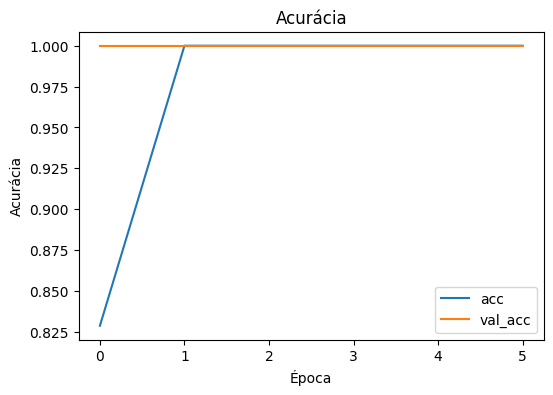

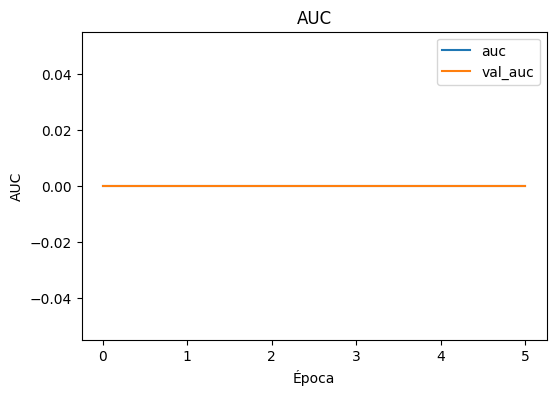

In [18]:

callbacks = [
    EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, mode="max", verbose=1),
    ModelCheckpoint("best_target_model.keras", monitor="val_auc", save_best_only=True, mode="max")
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Curva de treino
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.title('AUC')
plt.xlabel('Época')
plt.ylabel('AUC')
plt.legend()
plt.show()


## 10) Avaliação no conjunto de teste

In [19]:

test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Avaliação — Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")


Avaliação — Loss: 0.0000 | Acc: 1.0000 | AUC: 0.0000


## 11) Inferência em imagens com múltiplas faces

/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/lo

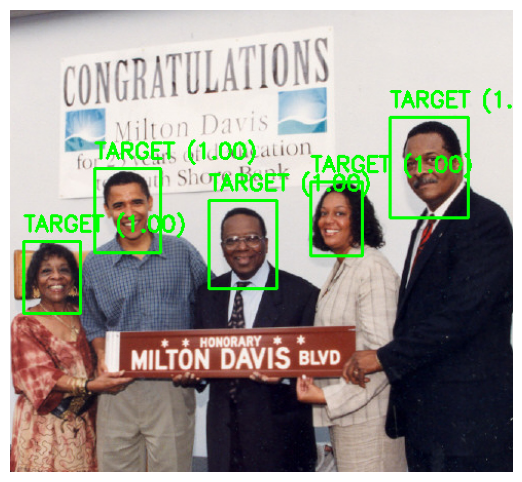

In [23]:

# Limite de decisão (threshold). Ajuste para ser mais conservador (maior) ou liberal (menor).
THRESHOLD = 0.6

def preprocess_face_for_model(face_rgb):
    face = cv2.resize(face_rgb, (IMG_SIZE, IMG_SIZE))
    face = face.astype(np.float32) / 255.0
    return np.expand_dims(face, axis=0)

def detect_and_recognize_image(image_path, show=True, threshold=THRESHOLD):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Falha ao ler a imagem:", image_path)
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img_rgb)

    if not faces:
        print("Nenhuma face detectada.")
        return

    for face in faces:
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)
        x2, y2 = x + w, y + h
        # aplica margem
        dx = int(w * MARGIN)
        dy = int(h * MARGIN)
        x = max(0, x - dx)
        y = max(0, y - dy)
        x2 = min(img_rgb.shape[1], x2 + dx)
        y2 = min(img_rgb.shape[0], y2 + dy)

        crop = img_rgb[y:y2, x:x2]
        if crop.size == 0:
            continue
        inp = preprocess_face_for_model(crop)
        prob = float(model.predict(inp, verbose=0)[0][0])
        label = "TARGET" if prob >= threshold else "DESCONHECIDO"
        score = f"{prob:.2f}"

        cv2.rectangle(img_rgb, (x,y), (x2,y2), (0,255,0) if label=="TARGET" else (255,0,0), 2)
        cv2.putText(img_rgb, f"{label} ({score})", (x, max(0,y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                    (0,255,0) if label=="TARGET" else (255,0,0), 2)

    if show:
        plt.figure(figsize=(8,6))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()

# Exemplo de uso (após upload de imagens no Colab):
detect_and_recognize_image("Obamamiltondavisteste.jpg")


## 12) Upload de imagens para teste (Colab)

Faça upload de uma ou mais imagens (jpg/png)...


Saving teste.jpg to teste (1).jpg
Processando: teste (1).jpg


/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())


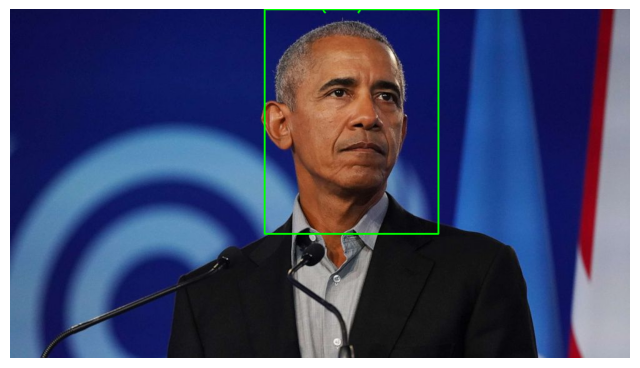

In [21]:

from google.colab import files

print("Faça upload de uma ou mais imagens (jpg/png)...")
uploaded = files.upload()

for fname in uploaded.keys():
    print("Processando:", fname)
    detect_and_recognize_image(fname, show=True, threshold=THRESHOLD)


## 13) Exportar modelo e metadados

In [22]:

model.save("modelo_reconhecimento_target.keras")
with open("metadados.json","w") as f:
    json.dump({"target_name": TARGET_NAME, "img_size": IMG_SIZE, "threshold": THRESHOLD}, f, ensure_ascii=False, indent=2)

print("Arquivos salvos:")
print("- modelo_reconhecimento_target.keras")
print("- metadados.json")


Arquivos salvos:
- modelo_reconhecimento_target.keras
- metadados.json



## 14) Próximos passos e melhorias
- **Aumentar o dataset** do TARGET (≥ 500 imagens) e coletar **outros negativos** (celebridades variadas) para generalizar melhor.
- **Aumentar a robustez** com *data augmentation* (flip, brilho, blur leve, corte).
- Trocar a CNN simples por **MobileNetV2/EfficientNet** com *fine-tuning*.
- Usar embeddings de face (ex.: FaceNet, ArcFace) e **classificação por similaridade** (SVM/kNN) para melhor desempenho.
- Ajustar o **limiar (threshold)** conforme a matriz de confusão desejada (menos falsos positivos vs. menos falsos negativos).
